In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

В работе две основные части:

**1) Работа с датасетом**

После различных идей было принято решение:

а) аугментировать тренировочный датасет путем увеличения количества сэмплов за счет перевода каждого текста на английский и потом обратно на русский, чтобы тупо не дублировать данные (чтобы сэмплы чем-то отличались).

б) объединить в тренировочном датасете колонки assessment, tags и text в один стринг для каждой строки. Идея в том, что assessment и tags могут иметь значимые данные для предсказания классов. Соответственно, в тестовом датасете (который и отправлялся на проверку в ods) таким же образом перед оценкой были объединены assessment, tags и text. 

**2) Обучение**

Были испробованы разные методы (основные - регрессия, bert и roberta). В итоге был сделан выбор в пользу мультилингвальной xml-roberta-large. В итоговом выборе из 3 решений на ods было представлено два варианта xml-roberta-large и один вариант xml-roberta-base с близкими значениями по качеству на паблике. В разделе с обучением будет представлен код по xml-roberta-large. Добавить тот самый код по base версии уже не представляется возможным, так как код модифицировался в процессе, но в целом он был такой же, как и для large. Да и вероятнее всего выигрышным сабмитом на привате был один сабмитов по xml-roberta-large (но все равно решил на всякий случай это обозначить).

Другой важной штукой по обучению стала, так сказать, впихуемость данных. У роберты ограничение на инпут в 512 токенов. В датасете были тексты со значительно бОльшим кол-вом токенов (максимальный - около 900). Для решения этой проблемы был применен чанкинг. Также в код обучения была встроена проверка по тестовому (финальному) датасету после каждой эпохи, чтобы было удобно загрузить какую-то эпоху в ods прямо во время обучения и посмотреть результаты. 

Все датасеты представлены в репе GitHub (аугментированный и объединенный (assessment, tags, text) датасет для обучения, объединенный тестовый датасет, финальные датасеты с предсказаниями для сабмита).

В целом, введение закончено. Переходим к коду.

**Аугментация данных**

In [1]:
import pandas as pd

In [10]:
#подгружаем тренировочный датасет (не обращайте внимание на цифру, я просто скачал датасет несколько раз, а удалять и переименовывать было лень)
df_messages = pd.read_csv('/kaggle/input/datasey/train.csv(1).csv')

In [11]:
df_messages

,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,8701,26325,2.0,{PRODUCTS_QUALITY},Привезли прокисший суп,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4619,8703,661,6.0,{DELIVERY},пойдет,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4620,8704,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}",Не дают абузить поддержка не возвращает деньги...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4621,8705,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая доставка в первую очередь, постоя...",1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import torch

# подгрузим модели для переводов с русского на английский и с английского на русский
en_model_name = 'Helsinki-NLP/opus-mt-ru-en'
ru_model_name = 'Helsinki-NLP/opus-mt-en-ru'
tokenizer_en = MarianTokenizer.from_pretrained(en_model_name)
model_en = MarianMTModel.from_pretrained(en_model_name)
tokenizer_ru = MarianTokenizer.from_pretrained(ru_model_name)
model_ru = MarianMTModel.from_pretrained(ru_model_name)

# для ускорения направляем модельки на гпу
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_en.to(device)
model_ru.to(device)

def back_translate(text):
    # токенизируем русский текст
    inputs = tokenizer_en(text, return_tensors="pt", padding=True).to(device)
    # переводим
    translated_to_en = model_en.generate(**inputs)
    text_en = tokenizer_en.batch_decode(translated_to_en, skip_special_tokens=True)
    
    # токенизируем английский текст
    inputs_en = tokenizer_ru(text_en, return_tensors="pt", padding=True).to(device)
    # переводим обратно на русский
    translated_back_to_ru = model_ru.generate(**inputs_en)
    return tokenizer_ru.batch_decode(translated_back_to_ru, skip_special_tokens=True)[0]

# применяем это дело к нашей колонке text и генерируем новую колонку augmented_text, при этом рисуем прогресс бар для наглядности, чтобы не стрессовать
df_messages['augmented_text'] = [back_translate(text) for text in tqdm(df_messages['text'], desc="Перевод туда-сюда")]



tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Перевод туда-сюда: 100%|██████████| 4623/4623 [36:06<00:00,  2.13it/s]  


In [5]:
#сохраняем
df_messages.to_csv('/kaggle/working/augmented_df.csv', encoding='utf-8')

In [17]:
#Посмотрим. Получилась новая колонка
df_messages

,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,...,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,augmented_text
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Маленький выбор товаров, я бы хотел больше, и,..."
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Быстрее.
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Непрерывная задержка с доставкой
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Надбавка и диапазон расстраиваются.
4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Вы можете отказаться от минимального заказа ил...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,8701,26325,2.0,{PRODUCTS_QUALITY},Привезли прокисший суп,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Они принесли кислый суп.
4619,8703,661,6.0,{DELIVERY},пойдет,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Все в порядке.
4620,8704,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}",Не дают абузить поддержка не возвращает деньги...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Они не дают тебе поддержку, они не возвращают ..."
4621,8705,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая доставка в первую очередь, постоя...",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Очень плохая поставка с самого начала, постоян..."


In [16]:
#сопоставим оригинал с аугментацией
df_messages[['text', 'augmented_text']]

,text,augmented_text
0,"Маленький выбор товаров, хотелось бы ассортиме...","Маленький выбор товаров, я бы хотел больше, и,..."
1,Быстро,Быстрее.
2,Доставка постоянно задерживается,Непрерывная задержка с доставкой
3,Наценка и ассортимент расстраивают,Надбавка и диапазон расстраиваются.
4,Можно немного скинуть минимальную сумму заказа...,Вы можете отказаться от минимального заказа ил...
...,...,...
4618,Привезли прокисший суп,Они принесли кислый суп.
4619,пойдет,Все в порядке.
4620,Не дают абузить поддержка не возвращает деньги...,"Они не дают тебе поддержку, они не возвращают ..."
4621,"Очень плохая доставка в первую очередь, постоя...","Очень плохая поставка с самого начала, постоян..."


Теперь необходимо как-бы переместить augmented_text под text в одну колонку с сохранением всех тегов, ассессментов, индексов и классов.

In [18]:
# загрузим наш новый датасет в две переменные
augmented_df = pd.read_csv('/kaggle/input/augmente/augmented_df.csv')
orig = pd.read_csv('/kaggle/input/augmente/augmented_df.csv')

In [19]:
# сделаем датасет только с аугментацией - заменим колонку text на augmented_text
augmented_df['text'] = augmented_df['augmented_text'] 

In [20]:
# и дропнем аугментированную колонку
augmented_df = augmented_df.drop(columns=['augmented_text'])


In [21]:
# а для "создания" оригинального датасета дропнем колонку с аугментацией. Вообще можно было просто взять оригинал, но тут так
original_df = orig.drop(columns=['augmented_text'])


In [22]:
# оригинал без всего лишнего
original_df

,Unnamed: 0.1,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,4618,8701,26325,2.0,{PRODUCTS_QUALITY},Привезли прокисший суп,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4619,4619,8703,661,6.0,{DELIVERY},пойдет,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4620,4620,8704,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}",Не дают абузить поддержка не возвращает деньги...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4621,4621,8705,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая доставка в первую очередь, постоя...",1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [9]:
# только аугментация
augmented_df

,Unnamed: 0.1,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, я бы хотел больше, и,...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстрее.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Непрерывная задержка с доставкой,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Надбавка и диапазон расстраиваются.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,1428,6.0,"{PRICE,PROMOTIONS}",Вы можете отказаться от минимального заказа ил...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,4618,8701,26325,2.0,{PRODUCTS_QUALITY},Они принесли кислый суп.,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4619,4619,8703,661,6.0,{DELIVERY},Все в порядке.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4620,4620,8704,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}","Они не дают тебе поддержку, они не возвращают ...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4621,4621,8705,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая поставка с самого начала, постоян...",1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
# теперь конкатенируем два датасета, чтобы получить один большой, и убедимся, что он увеличился ровно в 2 раза
combined_df = pd.concat([original_df, augmented_df], ignore_index=True)

print(f"Строки в ориге: {len(original_df)}, Строки в ауге: {len(augmented_df)}, Строки в общем датасете: {len(combined_df)}")

Строки в ориге: 4623, Строки в ауге: 4623, Строки в общем датасете: 9246


In [24]:
combined_df

,Unnamed: 0.1,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9241,4618,8701,26325,2.0,{PRODUCTS_QUALITY},Они принесли кислый суп.,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9242,4619,8703,661,6.0,{DELIVERY},Все в порядке.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9243,4620,8704,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}","Они не дают тебе поддержку, они не возвращают ...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9244,4621,8705,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая поставка с самого начала, постоян...",1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [12]:
# сохраним датасет, чтоб не потерять
combined_df.to_csv('/kaggle/working/correct_aug.csv', encoding='utf-8', index=False)

In [26]:
# теперь возьмем какой-нибудь индекс текста и проверим, правильно ли собран датасет. По идее под одним индексом должно быть две одинаковые строки.
combined_df[combined_df['index'] == 5652]




,Unnamed: 0.1,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4623,0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, я бы хотел больше, и,...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Аугментированный датасет готов. Теперь необходимо, чтобы assessment, tags и text совместились в одну строку в каждом примере.

In [27]:
# загрузим датасет
df_messages = pd.read_csv("/kaggle/input/corrected/correct_aug.csv")

# затем сделаем функцию, которая:
def preprocess_text_tags_and_assessment(row):
    text = row['text'] if isinstance(row['text'], str) else "" # берет текст из колонки text
    tags = row['tags'].replace('{', '').replace('}', '').replace(',', ' ') if isinstance(row['tags'], str) else "" # берет теги из колонки "tags", удаляя скобки и запятые
    assessment = str(row['assessment']) if pd.notnull(row['assessment']) else "" # берет оценку из assessment и переводит ее в стринг
    return f"{text.lower()} {tags.lower()} {assessment}" # и наконец возвращает стринг, состоящий из текста, тэгов и ассессмента, и все это в нижнем регистре

df_messages['combined_text'] = df_messages.apply(preprocess_text_tags_and_assessment, axis=1)

In [33]:
df_messages

,Unnamed: 0.1,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,...,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,combined_text
0,0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,"маленький выбор товаров, хотелось бы ассортиме..."
1,1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,...,0,0,0,0,0,0,0,0,0,быстро assortment price products_quality deliv...
2,2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,...,0,0,0,0,0,0,0,0,0,доставка постоянно задерживается delivery prom...
3,3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,...,0,0,0,0,0,0,0,0,0,наценка и ассортимент расстраивают price promo...
4,4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,можно немного скинуть минимальную сумму заказа...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9241,4618,8701,26325,2.0,{PRODUCTS_QUALITY},Они принесли кислый суп.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,они принесли кислый суп. products_quality 2.0
9242,4619,8703,661,6.0,{DELIVERY},Все в порядке.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,все в порядке. delivery 6.0
9243,4620,8704,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}","Они не дают тебе поддержку, они не возвращают ...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,"они не дают тебе поддержку, они не возвращают ..."
9244,4621,8705,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая поставка с самого начала, постоян...",1,0,0,0,...,0,0,0,0,0,0,0,0,0,"очень плохая поставка с самого начала, постоян..."


In [29]:
df_messages[['combined_text']]

,combined_text
0,"маленький выбор товаров, хотелось бы ассортиме..."
1,быстро assortment price products_quality deliv...
2,доставка постоянно задерживается delivery prom...
3,наценка и ассортимент расстраивают price promo...
4,можно немного скинуть минимальную сумму заказа...
...,...
9241,они принесли кислый суп. products_quality 2.0
9242,все в порядке. delivery 6.0
9243,"они не дают тебе поддержку, они не возвращают ..."
9244,"очень плохая поставка с самого начала, постоян..."


In [32]:
# получаем такой формат сэмпла для обучения
df_messages['combined_text'][2]

'доставка постоянно задерживается delivery promotions price assortment support 6.0'

Теперь датасет для тренировки модели полностью готов

Теперь подготовим наш тестовый датасет, через который будем прогонять модель каждую эпоху и сохранять результат. Код, в целом, такой же, как и выше.

In [35]:
import pandas as pd

df_test = pd.read_csv('/kaggle/input/datasey/test.csv(3).csv')

def preprocess_text_tags_and_assessment(row):
    text = row['text'] if isinstance(row['text'], str) else ""
    tags = row['tags'].replace('{', '').replace('}', '').replace(',', ' ') if isinstance(row['tags'], str) else ""
    assessment = str(row['assessment']) if pd.notnull(row['assessment']) else ""
    return f"{text.lower()} {tags.lower()} {assessment}"

df_test['combined_text'] = df_test.apply(preprocess_text_tags_and_assessment, axis=1)
df_test = df_test[['index', 'combined_text']]


In [36]:
df_test

,index,combined_text
0,3135,"последнее время думаю плохо, сроки доставки да..."
1,4655,цены намного выше магазинных но радуют акции p...
2,22118,"доставка за [num] минут, заказ даже не начали ..."
3,23511,ужасно долгая доставка delivery 0.0
4,45,добрый вечер! вы большие молодцы. меня всё уст...
...,...,...
9010,3523,задержка с доставкой не даете промокод на скид...
9011,24925,очень удобный формат сервиса и очень маленький...
9012,6327,"сумма заказа почти всегда высокая, что зачасту..."
9013,530,"часто, заказываю у вас молочную продукцию, при..."


In [37]:
df_test['combined_text'][0]

'последнее время думаю плохо, сроки доставки давно не [num] мин, а цена услуг при этом выше аналогов delivery 3.0'

In [47]:
# сохраним тестовый датасет, чтобы не потерять
df_test.to_csv("/kaggle/working/test_comb.csv", encoding='utf-8', index=False)

Теперь наш тестовый датасет готов. Приступим к обучению.

Обучать будем модель xlm-roberta-large.

Еще раз загрузим сохраненный датасет и проверим, и посмотрим перед обученим на тестовый датасет

In [42]:
combined_df = pd.read_csv("/kaggle/input/corrected/correct_aug.csv")

In [44]:
combined_df

,Unnamed: 0.1,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,1428,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9241,4618,8701,26325,2.0,{PRODUCTS_QUALITY},Они принесли кислый суп.,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9242,4619,8703,661,6.0,{DELIVERY},Все в порядке.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9243,4620,8704,1870,6.0,"{PROMOTIONS,PRICE,SUPPORT,PRODUCTS_QUALITY}","Они не дают тебе поддержку, они не возвращают ...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9244,4621,8705,22650,2.0,"{DELIVERY,PRODUCTS_QUALITY}","Очень плохая поставка с самого начала, постоян...",1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [45]:
df_test

,index,combined_text
0,3135,"последнее время думаю плохо, сроки доставки да..."
1,4655,цены намного выше магазинных но радуют акции p...
2,22118,"доставка за [num] минут, заказ даже не начали ..."
3,23511,ужасно долгая доставка delivery 0.0
4,45,добрый вечер! вы большие молодцы. меня всё уст...
...,...,...
9010,3523,задержка с доставкой не даете промокод на скид...
9011,24925,очень удобный формат сервиса и очень маленький...
9012,6327,"сумма заказа почти всегда высокая, что зачасту..."
9013,530,"часто, заказываю у вас молочную продукцию, при..."


In [3]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import torch
import os

# передадим наш датасет в переменную df_messages (изначально переменная называлась так, поэтому сделаем это для удобства)
df_messages = combined_df

# Та же функция, которая использовалась до этого для совмещения тегов, ассессментов и текстов. Здесь она встроена в код обучения, чтобы все делалось одной комбинацией клавиш, 
# а до этого я объяснял это отдельно, чтобы было более последовательно. Так как мы вновь загрузили только полный аугментированный датасет без совмещения, этот шаг будет сделан еще раз в обучении.
def preprocess_text_tags_and_assessment(row):
    text = row['text'] if isinstance(row['text'], str) else ""
    tags = row['tags'].replace('{', '').replace('}', '').replace(',', ' ') if isinstance(row['tags'], str) else ""
    assessment = str(row['assessment']) if pd.notnull(row['assessment']) else ""
    return f"{text.lower()} {tags.lower()} {assessment}"

df_messages['combined_text'] = df_messages.apply(preprocess_text_tags_and_assessment, axis=1)

# найдем и обозначим классы
trend_columns = [col for col in df_messages.columns if col.startswith('trend_id_res')]
df_messages['labels'] = df_messages[trend_columns].values.astype(np.float32).tolist()

# ресетним индкесы и разделим выборку на обучающую и валидационную в соотношении 0.8 и 0.2
train_df, test_df = train_test_split(df_messages[['combined_text', 'labels']].reset_index(drop=True), test_size=0.2, random_state=42)

# подгрузим токенизатор роберты
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

# обозначим функцию для чанкинга. Максимальный размер, который дает роберта - 512, и сделаем страйд на 256, чтобы чанки оверлапились и мы не теряли потенциально важный контекст
def split_into_chunks(text, labels, max_length=512, stride=256):
    tokenized_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, truncation=False)
    tokens = tokenized_text['input_ids']
    chunks = []
    labels_list = []

    num_special_tokens = tokenizer.num_special_tokens_to_add(pair=False)
    chunk_length = max_length - num_special_tokens

    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i + chunk_length]
        if len(chunk) > 0:
            chunk = tokenizer.build_inputs_with_special_tokens(chunk[:chunk_length])
            if len(chunk) <= max_length:
                chunks.append(chunk)
                labels_list.append(labels)
    return chunks, labels_list

# чтоб чанки сохраняли свои соответствующие классы
def preprocess_function(examples):
    all_chunks = []
    all_labels = []
    for text, labels in zip(examples['combined_text'], examples['labels']):
        chunks, chunk_labels = split_into_chunks(text, labels)
        all_chunks.extend(chunks)
        all_labels.extend(chunk_labels)
    return {'input_ids': all_chunks, 'labels': all_labels}

# Преобразуем в нужный формат
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['combined_text'], desc="Processing Train Dataset")
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=['combined_text'], desc="Processing Test Dataset")

# подгрузим нашу мультилингвальную роберту для мультиклассификации и обозначим кол-во классов
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-large',
    num_labels=len(trend_columns),
    problem_type="multi_label_classification"
)

# обозначим наш акьюраси на всякий, чтобы точно она считалась таким образом, чтобы сравнивать предсказанные и истинные классы
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    correct_predictions = np.all(predictions == labels, axis=1)
    accuracy = np.mean(correct_predictions)
    return {"accuracy": accuracy}


# Обозначим гиперпараметры для обучения. Обучим на 30 эпохах и посмотрим на динамику.
#При этом для экономии места будем сохранять только самую крутую модель по метрике accuracy
training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.01,
    logging_dir='.',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    save_total_limit=1
)

# Теперь класс для проверки на нашем финальном тестовом датасете (который загружаем в ods) после каждой эпохи. Результат сохраним сразу в правильном формате csv, чтобы удобно было отправлять.
class SavePredictionsCallback(TrainerCallback):
    def __init__(self, tokenizer, separate_test_path, output_dir, device):
        self.tokenizer = tokenizer # токенизатор модели
        self.separate_test_path = separate_test_path # обозначение пути для тестового датасета
        self.output_dir = output_dir
        self.device = device

    def on_evaluate(self, args, state, control, model=None, tokenizer=None, **kwargs):
        # загружаем тестовый датасет
        df_test = pd.read_csv(self.separate_test_path)

        # модель на нужный девайс
        model.to(self.device)
        model.eval()

        # токенизируем тестовый датасет
        inputs = self.tokenizer(df_test['combined_text'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # делаем предсказания батчами для ускорения
        predictions = predict_in_batches(model, inputs)

        # сохраняем предсказания в датасет, переводим их в нужный формат (только предсказанные классы через пробел), оставляем две колонки (формат для загрузки на одс), и сохраняем с номером эпохи
        df_test['predicted_classes'] = predictions
        df_test['target'] = df_test['predicted_classes'].apply(transform_prediction_to_string)
        df_done = df_test[['index', 'target']]
        output_file = os.path.join(self.output_dir, f'test_pred_epoch_{state.epoch}.csv')
        df_done.to_csv(output_file, encoding='utf-8', index=False)

# функция для предсказания по батчам для ускорения процесса. Также нарисуем прогресс бар для наглядности.
def predict_in_batches(model, inputs, batch_size=16):
    predictions = []
    for i in tqdm(range(0, len(inputs['input_ids']), batch_size)):
        batch_inputs = {k: v[i:i + batch_size] for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**batch_inputs)
            
        batch_predictions = (outputs.logits > 0).int().cpu().numpy()
        predictions.extend(batch_predictions)
    
    return predictions

# функция для перевода предсказаний в стринги
def transform_prediction_to_string(prediction):
    class_indices = [str(idx) for idx, val in enumerate(prediction) if val == 1]
    return " ".join(class_indices) if class_indices else ""

# подрубаем гпу
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# готовим трейнер. Сделаем early stop на 15 эпох, если не будет улучшений на протяжении 15 эпох (спойлер - не будет). Там же укажем путь к нашему тестовому (финальному) датасету
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=15),
               SavePredictionsCallback(
                   tokenizer=tokenizer,
                   separate_test_path='/kaggle/input/test-dat/test_comb.csv',
                   output_dir='/kaggle/working/',
                   device=device
               )]
)

# обучаем
trainer.train()

# имеем результат
results = trainer.evaluate()
print("Evaluation results:", results)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing Train Dataset:   0%|          | 0/7396 [00:00<?, ? examples/s]

Processing Test Dataset:   0%|          | 0/1850 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: http

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.098100,0.084622,0.172973
2,0.063000,0.062752,0.381622
3,0.060900,0.053716,0.449730
4,0.052300,0.049781,0.500000
5,0.040800,0.045252,0.541622
6,0.031100,0.044084,0.550270
7,0.021600,0.040813,0.589189
8,0.018600,0.039291,0.612432
9,0.015000,0.038124,0.636216
10,0.014100,0.037389,0.639459


100%|██████████| 564/564 [01:33<00:00,  6.04it/s]


100%|██████████| 564/564 [01:33<00:00,  6.05it/s]


Evaluation results: {'eval_loss': 0.04077828302979469, 'eval_accuracy': 0.7254054054054054, 'eval_runtime': 14.7048, 'eval_samples_per_second': 125.809, 'eval_steps_per_second': 15.777, 'epoch': 30.0}


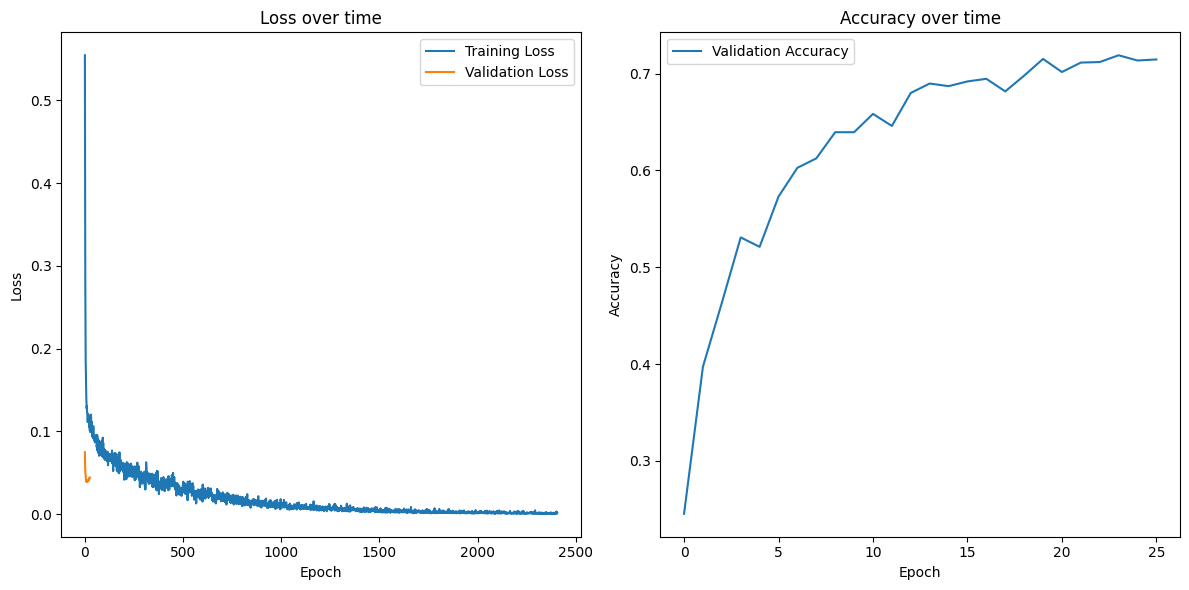

In [12]:
#нарисуем графики, чтоб было наглядно видно, как все обучалось
import matplotlib.pyplot as plt

training_loss = []
eval_loss = []
training_accuracy = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        training_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])


plt.figure(figsize=(12, 6))

# лосс
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# акураси
plt.subplot(1, 2, 2)
plt.plot(eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()

plt.tight_layout()
plt.show()

В целом издалека лосс падает, а акураси растет

Теперь сохраним модельку на наш хаггинг фейс, чтобы была. 

In [4]:
from huggingface_hub import HfApi 
from huggingface_hub import login
import os

hf_api_token = os.getenv('')
login(token=hf_api_token)
   

In [5]:
from huggingface_hub import HfApi, HfFolder, Repository

repo_name = "Gnider/hack_final_30ep_xmlroberta_aug9000"

model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)
    

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Gnider/hack_final_30ep_xmlroberta_aug9000/commit/77c4be907b87ae6545c853149f310b002474ce32', commit_message='Upload tokenizer', commit_description='', oid='77c4be907b87ae6545c853149f310b002474ce32', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Gnider/hack_final_30ep_xmlroberta_aug9000', endpoint='https://huggingface.co', repo_type='model', repo_id='Gnider/hack_final_30ep_xmlroberta_aug9000'), pr_revision=None, pr_num=None)

Ниже код для независимой проверки тестового датасета (все то же самое, что было выше, только отдельно от обучения).

In [49]:
import pandas as pd

df_test = pd.read_csv('/kaggle/input/datasey/test.csv(3).csv')

def preprocess_text_tags_and_assessment(row):
    text = row['text'] if isinstance(row['text'], str) else ""
    tags = row['tags'].replace('{', '').replace('}', '').replace(',', ' ') if isinstance(row['tags'], str) else ""
    assessment = str(row['assessment']) if pd.notnull(row['assessment']) else ""
    return f"{text.lower()} {tags.lower()} {assessment}"

df_test['combined_text'] = df_test.apply(preprocess_text_tags_and_assessment, axis=1)
df_test = df_test[['index', 'combined_text']]


In [50]:
inputs = tokenizer(df_test['combined_text'].tolist(), truncation=True, padding=True, max_length=2048, return_tensors='pt')

In [ ]:
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_in_batches(model, inputs, batch_size=16):
    predictions = []
    for i in tqdm(range(0, len(inputs['input_ids']), batch_size)):
        batch_inputs = {k: v[i:i + batch_size].to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**batch_inputs)
            
        batch_predictions = (outputs.logits > 0).int().cpu().numpy()
        predictions.extend(batch_predictions)
    
    return predictions

inputs = tokenizer(df_test['combined_text'].tolist(), truncation=True, padding=True, max_length=2048, return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}  
predictions = predict_in_batches(model, inputs, batch_size=16)
df_test['predicted_classes'] = predictions

def transform_prediction_to_string(prediction):
    class_indices = [str(idx) for idx, val in enumerate(prediction) if val == 1]
    return " ".join(class_indices) if class_indices else ""

df_test['target'] = df_test['predicted_classes'].apply(transform_prediction_to_string)
df_done = df_test[['index', 'target']]
df_done.to_csv('/kaggle/working/test_pred2.csv', encoding = 'utf-8', index=False)

In [21]:
# тут отдельный пример с другим названием колонки (short_pred вместо target)
df_test['short_pred'] = df_test['predicted_classes'].apply(transform_prediction_to_string)

print(df_test)

      Unnamed: 0  index  assessment                                      tags  \
0              1   3135         3.0                                {DELIVERY}   
1              3   4655         2.0               {PRICE,DELIVERY,ASSORTMENT}   
2              5  22118         2.0  {CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}   
3              7  23511         0.0                                {DELIVERY}   
4              8     45         6.0                   {ASSORTMENT,PROMOTIONS}   
...          ...    ...         ...                                       ...   
9010       16992   3523         3.0                  {PRICE,SUPPORT,DELIVERY}   
9011       16993  24925         6.0       {PRICE,PRODUCTS_QUALITY,ASSORTMENT}   
9012       16994   6327         6.0             {PAYMENT,ASSORTMENT,DELIVERY}   
9013       16997    530         3.0       {PRODUCTS_QUALITY,SUPPORT,DELIVERY}   
9014       16998  20221         6.0    {ASSORTMENT,PRICE,PROMOTIONS,DELIVERY}   

                           

In [22]:
df_done = df_test[['index', 'short_pred']]

In [23]:
df_done

,index,short_pred
0,3135,1 2 12
1,4655,12
2,22118,2 35
3,23511,0
4,45,
...,...,...
9010,3523,37
9011,24925,12 22 28
9012,6327,8
9013,530,15 40


In [ ]:
df_done.rename(columns={'short_pred': 'target'}, inplace=True) # поменяем название на нужное, чтобы одс его принял


In [25]:
df_done.to_csv('/kaggle/working/test_pred2.csv', encoding = 'utf-8', index=False) # сохраняем и отправляем

Напоследов, чисто для приколу, глянем распределение классов. Очевидно, что оно не самое равномерное.

Распределение классов:
 trend_id_res0     837
trend_id_res12    624
trend_id_res2     597
trend_id_res27    530
trend_id_res28    420
trend_id_res3     361
trend_id_res19    360
trend_id_res1     347
trend_id_res30    306
trend_id_res18    231
trend_id_res16    191
trend_id_res36    167
trend_id_res8     140
trend_id_res20    132
trend_id_res4     126
trend_id_res11    108
trend_id_res21     99
trend_id_res10     96
trend_id_res15     81
trend_id_res14     73
trend_id_res40     72
trend_id_res23     65
trend_id_res29     61
trend_id_res35     58
trend_id_res5      52
trend_id_res31     50
trend_id_res37     46
trend_id_res43     44
trend_id_res39     44
trend_id_res42     35
trend_id_res7      35
trend_id_res13     34
trend_id_res47     31
trend_id_res48     29
trend_id_res33     28
trend_id_res38     28
trend_id_res44     27
trend_id_res26     27
trend_id_res22     25
trend_id_res41     21
trend_id_res6      21
trend_id_res25     13
trend_id_res32     13
trend_id_res49     12
trend_id

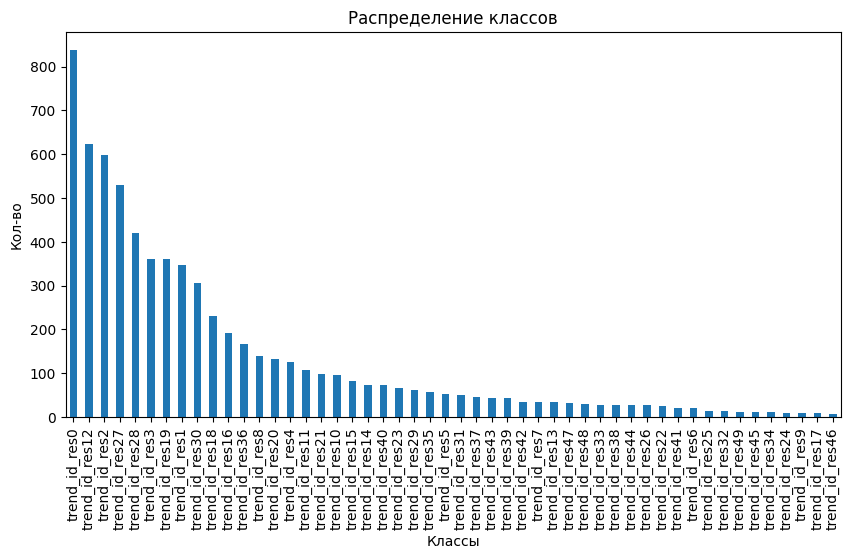

In [52]:
import pandas as pd

df_messages = pd.read_csv('/kaggle/input/datasey/train.csv(1).csv')

trend_columns = [col for col in df_messages.columns if col.startswith('trend_id_res')]

class_distribution = df_messages[trend_columns].sum().sort_values(ascending=False)
print("Распределение классов:\n", class_distribution)

total_samples = len(df_messages)
samples_with_no_class = (df_messages[trend_columns].sum(axis=1) == 0).sum()
print(f"Всего сэмплов: {total_samples}")
print(f"Сэмплы без классов: {samples_with_no_class}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
class_distribution.plot(kind='bar')
plt.title("Распределение классов")
plt.xlabel("Классы")
plt.ylabel("Кол-во")
plt.show()
